In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from plotnine import *

In [85]:
class hybrid_recommendation_model():
    def __init__(self):
        self.load_data()

    def load_data(self):
        self.STEAM_USERS  = pd.read_csv("data/process_data/steam_users.csv", encoding="UTF-8")
        self.STEAM_GAMES = pd.read_csv("data/process_data/steam_games.csv", encoding="UTF-8")

    def split_data(self):
        train_users_data, test_users_data = train_test_split(self.STEAM_USERS, test_size= 0.2, random_state=42)
        train_users_exists =  train_users_data['user'].unique()
        # Lọc các user trong tập test không có trong tập train 
        train_non_exists = test_users_data[~test_users_data['user'].isin(train_users_exists)]
        # thêm các user trong tập test không có trong tập train
        self.train_users_data = pd.concat([train_users_data, train_non_exists])
        # Lọc các user tập test có trong tập train 
        self.test_users_data = test_users_data[test_users_data['user'].isin(train_users_exists)]    

    def fit(self):
        self.split_data()
        self.collaborative_filtering_model()
        self.content_based_filtering_model()

    def unique_game(self):
        name_game_users = self.STEAM_USERS["name"].values
        name_game_games = self.STEAM_GAMES["name"].values

        return sorted(np.union1d(name_game_users, name_game_games))
    
    def collaborative_filtering_model(self):
        # Tạo ma trận user-game
        self.utility_matrix = self.train_users_data.pivot_table(index='name', columns='user', values='hours_rating', fill_value=0)

        # Tính độ tương đồng game-game
        self.game_similarity_matrix = cosine_similarity(self.utility_matrix)

    def content_based_filtering_model(self):
        # Tạo một vectorizer TF-IDF cho các đặc trưng nội dung
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
        # Tạo ma trận TF-IDF từ các đặc trưng nội dung (ví dụ: name, tag, details,description)
        tfidf_matrix = tfidf_vectorizer.fit_transform(self.STEAM_GAMES['tags']+ ' ' + self.STEAM_GAMES['details'] + ' ' + self.STEAM_GAMES['description'])
        # Thiết lập kích thước chunk cho việc xử lý ma trận TF-IDF
        chunk_size = 800
        # Lấy số lượng chunk
        num_chunks = tfidf_matrix.shape[0] // chunk_size + 1
        # Khởi tạo ma trận tương tự cosine
        self.cosine_similarities = np.zeros((tfidf_matrix.shape[0], tfidf_matrix.shape[0]), dtype=np.float32)
        # Tính toán ma trận tương tự cosine theo từng phần
        for i in range(num_chunks):
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, tfidf_matrix.shape[0])
            # Lấy đoạn ma trận TF-IDF
            chunk_matrix = tfidf_matrix[start_idx:end_idx]
            # Tính độ tương tự cho từng đoạn
            chunk_cosine_similarities = cosine_similarity(chunk_matrix, tfidf_matrix)
            # Cập nhật ma trận độ tương đồng cosine bằng các giá trị của đoạn con
            self.cosine_similarities[start_idx:end_idx, :] = chunk_cosine_similarities

    def compute_prediction(self, userid, itemid):
        user_rating = self.utility_matrix.loc[:,userid]
        index = self.utility_matrix.index.get_loc(itemid)
        item_similarity = self.game_similarity_matrix[index]
        
        numerate = np.dot(user_rating, item_similarity)
        denom = item_similarity[user_rating > 0].sum()
                
        if denom == 0 or numerate == 0:
            return user_rating[user_rating>0].mean()
        
        return numerate / denom
    
    def draw_chart(self):
        # Vẽ biểu đồ
        plt.plot(self.test_real[:50], label='Thực tế', marker='o')
        plt.plot(self.pred[:50], label='Dự đoán', marker='x')

        # Đặt nhãn cho trục x và y
        plt.xlabel('Index')
        plt.ylabel('Giá trị')

        # Hiển thị chú thích
        plt.legend()

        # Hiển thị biểu đồ
        plt.show()

    def compute_rmse(self, **kwargs):
        test_set = self.test_users_data[['user', 'name']].to_numpy()
        self.test_real = self.test_users_data['hours_rating'].to_numpy()
        self.pred = []
        for data in test_set:
            res = self.compute_prediction(userid = data[0],
                            itemid = data[1],
                            **kwargs)
            self.pred.append(res)

        rmse = np.sqrt(np.mean(self.test_real - self.pred)**2)
        return rmse

    def calculate_user_rating(self, user_id, similarity_mtx, utility):
        user_rating = utility.loc[:,user_id]
        pred_rating = user_rating.copy()

        default_rating = user_rating[user_rating>0].mean()
        numerate = np.dot(similarity_mtx, user_rating)
        corr_sim = similarity_mtx[:, user_rating >0]
        
        for i, rating in enumerate(pred_rating):
            temp = 0
            if rating < 1:
                w_r = numerate[i]
                sum_w = corr_sim[i,:].sum()
                if w_r == 0 or sum_w == 0:
                    temp = default_rating
                else:
                    temp = w_r / sum_w
                pred_rating.iloc[i] = temp
        return pred_rating

    def recommendation(self, user, game, top_n):
        n = round(top_n/2)

        ### show Content-based filtering
        game_index = self.STEAM_GAMES[self.STEAM_GAMES['name'] == game].index[0]
        game_data  = self.STEAM_GAMES.iloc[game_index]
        similar_indices = sorted(enumerate(self.cosine_similarities[game_index]), key=lambda x: x[1], reverse=True)
        self.print_content_model(game_data, similar_indices, n)
        
        ### show Collaborative filtering
        pred_rating = self.calculate_user_rating(user, self.game_similarity_matrix, self.utility_matrix)
        user_rating = self.utility_matrix.loc[:,user]
        top_item = sorted(range(1,len(pred_rating)), key = lambda i: -1*pred_rating.iloc[i])
        top_item = list(filter(lambda x: user_rating.iloc[x]==0.0, top_item))
        self.print_collaborative_model(user, pred_rating, top_item, top_n-n)

    def print_content_model(self, game_data, similar_indices, top_n):
        print(f"Những game tương đồng với [{game_data['name']}] thể loại: \n[{game_data['tags']}]")
        recommended_games_data = self.STEAM_GAMES.iloc[[i[0] for i in similar_indices[1:top_n]]]
        for _, data in recommended_games_data.iterrows():
            print(f"\tName: {data['name']} \n\tTags: {data['tags']}\n")

    def print_collaborative_model(self, user, pred_rating, top_item, top_n):
        print(f"Những game có thể [{user}] yêu thích:")
        for i in top_item[:top_n]:
            print(f"\tName: {self.utility_matrix.index[i]} \n\tRating: {pred_rating.iloc[i]}\n")
        

In [86]:
model = hybrid_recommendation_model()
model.fit()

In [87]:
rmse = model.compute_rmse()
print(f"RMSE = {rmse}")

RMSE = 0.06849331593011844


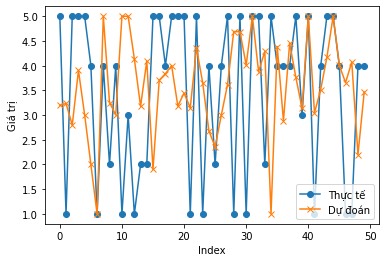

In [88]:
model.draw_chart()

In [89]:
list_game = model.unique_game()
list_game = random.sample(list_game, 100)
for i in list_game[:10]:
    print(i)

Happy Anime Puzzle
Welcome To... Chichester 2 Script
Saints Row IV - Bling Bling Pack
Peace Duke
Rocksmith® 2014 – Queensrÿche Song Pack
Bloons TD 5 - Tribal Boomerang Thrower Skin
NetherWorld
Silence
Realms of Arkania: Blade of Destiny
Rocksmith® 2014 Edition – Remastered – Radiohead - “There There”


In [90]:
user = 76767
game = "JumpStream"
model.recommendation(user, game, top_n=10)

Những game tương đồng với [JumpStream] thể loại: 
[Free to Play,Action,Indie]
	Name: Comedy Night 
	Tags: Multiplayer,Comedy,Casual,Memes,Simulation,Indie,Great Soundtrack,Dating Sim,Family Friendly

	Name: Book of Demons - Dungeons & Streamers 
	Tags: Action,Adventure,RPG,Indie,Casual

	Name: Killing Room 
	Tags: Action,RPG,Indie,Rogue-like,FPS,Singleplayer,Replay Value,Dark,Rogue-lite,Perma Death,Comedy,Horror,Procedural Generation,Multiple Endings,Gore,Difficult

	Name: LingeriesOffice 
	Tags: Indie

Những game có thể [76767] yêu thích:
	Name: Medieval II Total War 
	Rating: 4.3267992547731975

	Name: Counter-Strike Condition Zero 
	Rating: 4.315199756024984

	Name: Call of Duty Black Ops 
	Rating: 4.239297692913273

	Name: Half-Life 2 Deathmatch 
	Rating: 4.187592532338756

	Name: Battlefield Bad Company 2 
	Rating: 4.183050907947678

